**1. Car Price Prediction Model**  
**2. House Price Prediction Model**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline
from statsmodels.stats.diagnostic import normal_ad
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson
from scipy import stats

In [ ]:
from google.colab import drive
import pandas as pd

# Attempt to mount Google Drive.
# Setting force_remount=True can help if a previous mount was interrupted or failed.
try:
    drive.mount('/content/drive', force_remount=True)
except Exception as e:
    print(f"Mount failed with error: {e}")
    print("Attempting to unmount and remount.")
    # If mounting fails, try unmounting first and then remounting
    try:
        drive.flush_and_unmount()
        print("Drive unmounted successfully.")
        drive.mount('/content/drive')
        print("Drive remounted successfully after unmounting.")
    except Exception as e_remount:
        print(f"Remount after unmount failed: {e_remount}")
        print("Please try running the cell again. If it persists, try restarting the runtime.")

# After successful (re)mounting, the rest of your code can proceed

# Make sure the file path is correct after mounting
try:
    df = pd.read_csv('/content/drive/MyDrive/Sem 7/ML/car data.csv')
    print("Shape:", df.shape)
    print(df.head()) # print head here as well for confirmation
except FileNotFoundError:
    print("Error: car data.csv not found. Please check the file path in your Google Drive.")
    # Define df as None or an empty DataFrame in case of error
    # This prevents NameError later, though subsequent operations will fail
    df = None
except Exception as e_read:
    print(f"Error reading CSV file: {e_read}")
    # Define df as None or an empty DataFrame in case of error
    df = None

# Now you can safely use df if it was successfully loaded
if df is not None:
    df.info()

Mounted at /content/drive
Shape: (301, 9)
  Car_Name  Year  Selling_Price  Present_Price  Kms_Driven Fuel_Type  \
0     ritz  2014           3.35           5.59       27000    Petrol   
1      sx4  2013           4.75           9.54       43000    Diesel   
2     ciaz  2017           7.25           9.85        6900    Petrol   
3  wagon r  2011           2.85           4.15        5200    Petrol   
4    swift  2014           4.60           6.87       42450    Diesel   

  Seller_Type Transmission  Owner  
0      Dealer       Manual      0  
1      Dealer       Manual      0  
2      Dealer       Manual      0  
3      Dealer       Manual      0  
4      Dealer       Manual      0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Car_Name       301 non-null    object 
 1   Year           301 non-null    int64  
 2   Selling_Price  301 non-n

In [ ]:
#Step 2: Preprocess the Dataset
#i. Remove meaningless columns
df.info()
# Check if 'Car_Name' column exists before attempting to drop it
if 'Car_Name' in df.columns:
    # Print the number of unique values before dropping (optional)
    # print(f"Number of unique car names: {df['Car_Name'].nunique()}")
    df.drop(['Car_Name'], axis=1, inplace=True)
else:
    print("Column 'Car_Name' not found. It may have been dropped already.")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Age            301 non-null    int64  
 1   Selling_Price  301 non-null    float64
 2   Present_Price  301 non-null    float64
 3   Kms_Driven     301 non-null    int64  
 4   Fuel_Type      301 non-null    object 
 5   Seller_Type    301 non-null    object 
 6   Transmission   301 non-null    object 
 7   Owner          301 non-null    int64  
dtypes: float64(2), int64(3), object(3)
memory usage: 18.9+ KB
Column 'Car_Name' not found. It may have been dropped already.


In [ ]:
#ii. Remove the null values
print(df.isnull().sum())
df = df.dropna()



Age              0
Selling_Price    0
Present_Price    0
Kms_Driven       0
Fuel_Type        0
Seller_Type      0
Transmission     0
Owner            0
dtype: int64


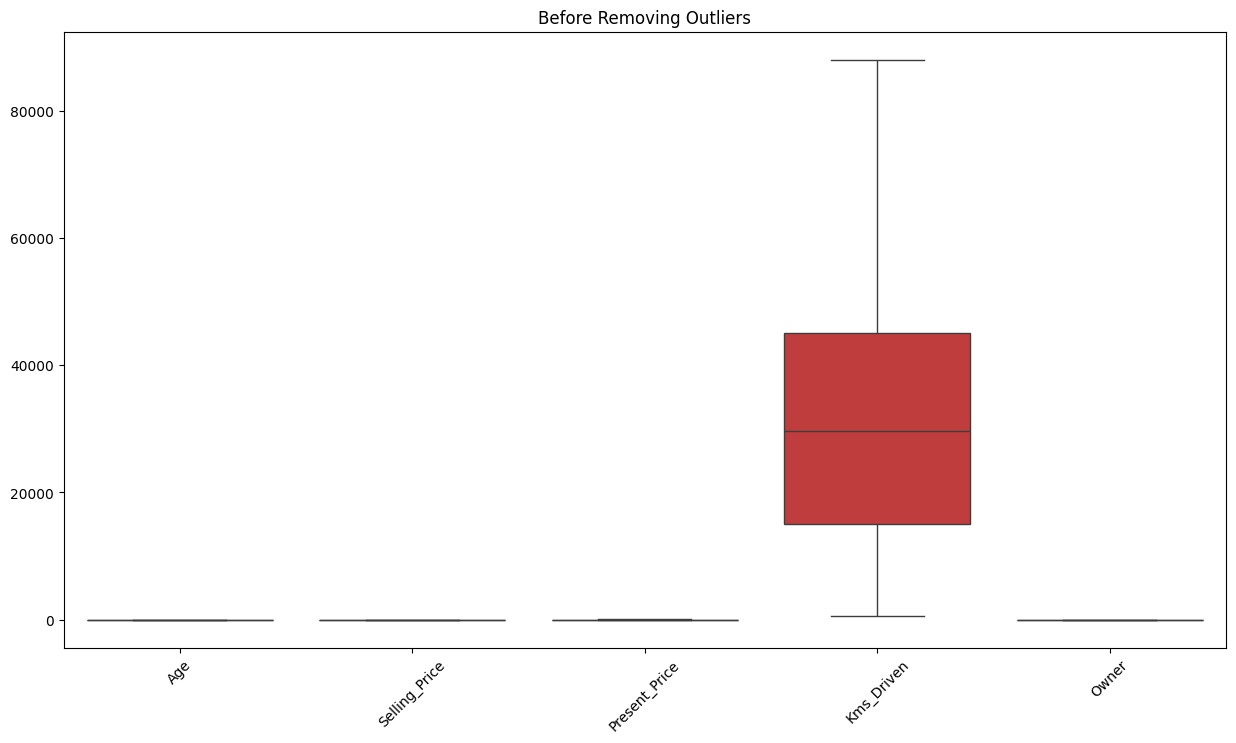

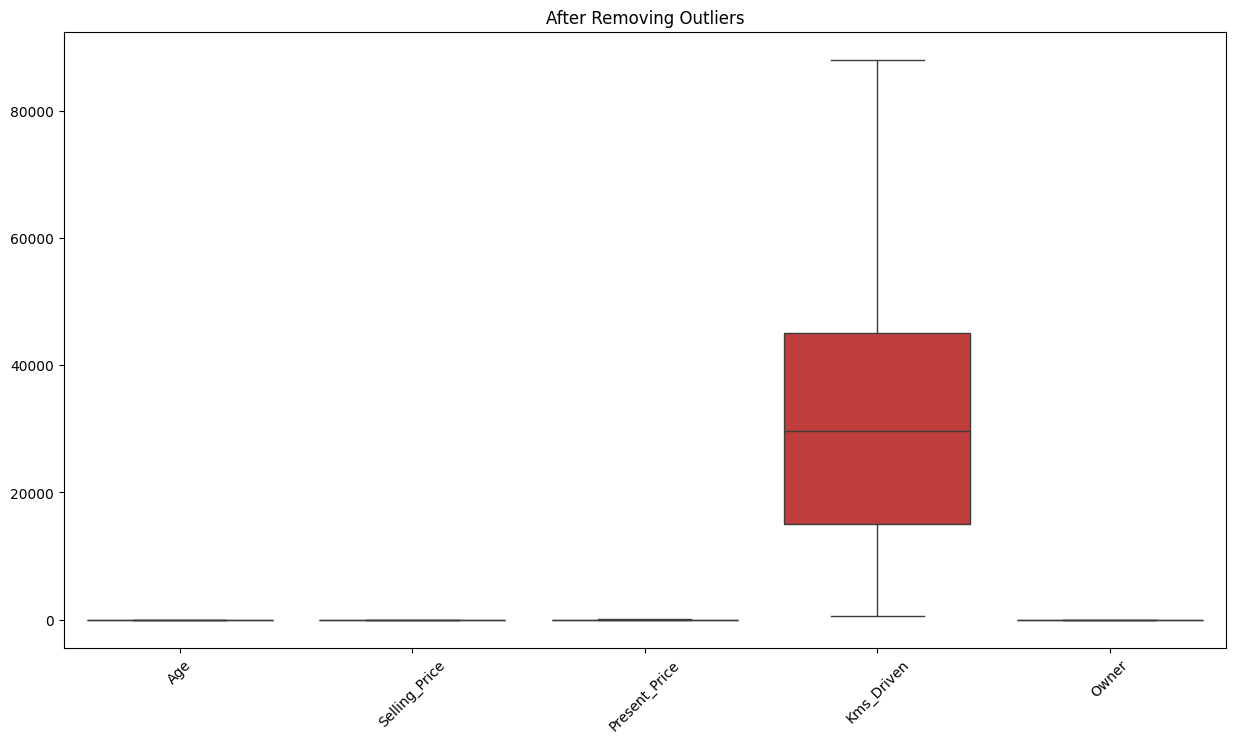

In [ ]:

# Select only numeric columns
numeric_df = df.select_dtypes(include=['number'])

# Show boxplots before removing outliers
if not numeric_df.empty:
    plt.figure(figsize=(15, 8))
    sns.boxplot(data=numeric_df)
    plt.title("Before Removing Outliers")
    plt.xticks(rotation=45)
    plt.show()

    # Calculate IQR
    Q1 = numeric_df.quantile(0.25)
    Q3 = numeric_df.quantile(0.75)
    IQR = Q3 - Q1

    # Find outliers
    outlier_condition = ((numeric_df < (Q1 - 1.5 * IQR)) | (numeric_df > (Q3 + 1.5 * IQR))).any(axis=1)

    # Remove outliers
    df = df[~df.index.isin(numeric_df[outlier_condition].index)]

    # Update numeric_df after outlier removal
    numeric_df = df.select_dtypes(include=['number'])

    # Show boxplots after removing outliers
    plt.figure(figsize=(15, 8))
    sns.boxplot(data=numeric_df)
    plt.title("After Removing Outliers")
    plt.xticks(rotation=45)
    plt.show()
else:
    print("No numeric columns found to calculate outliers.")


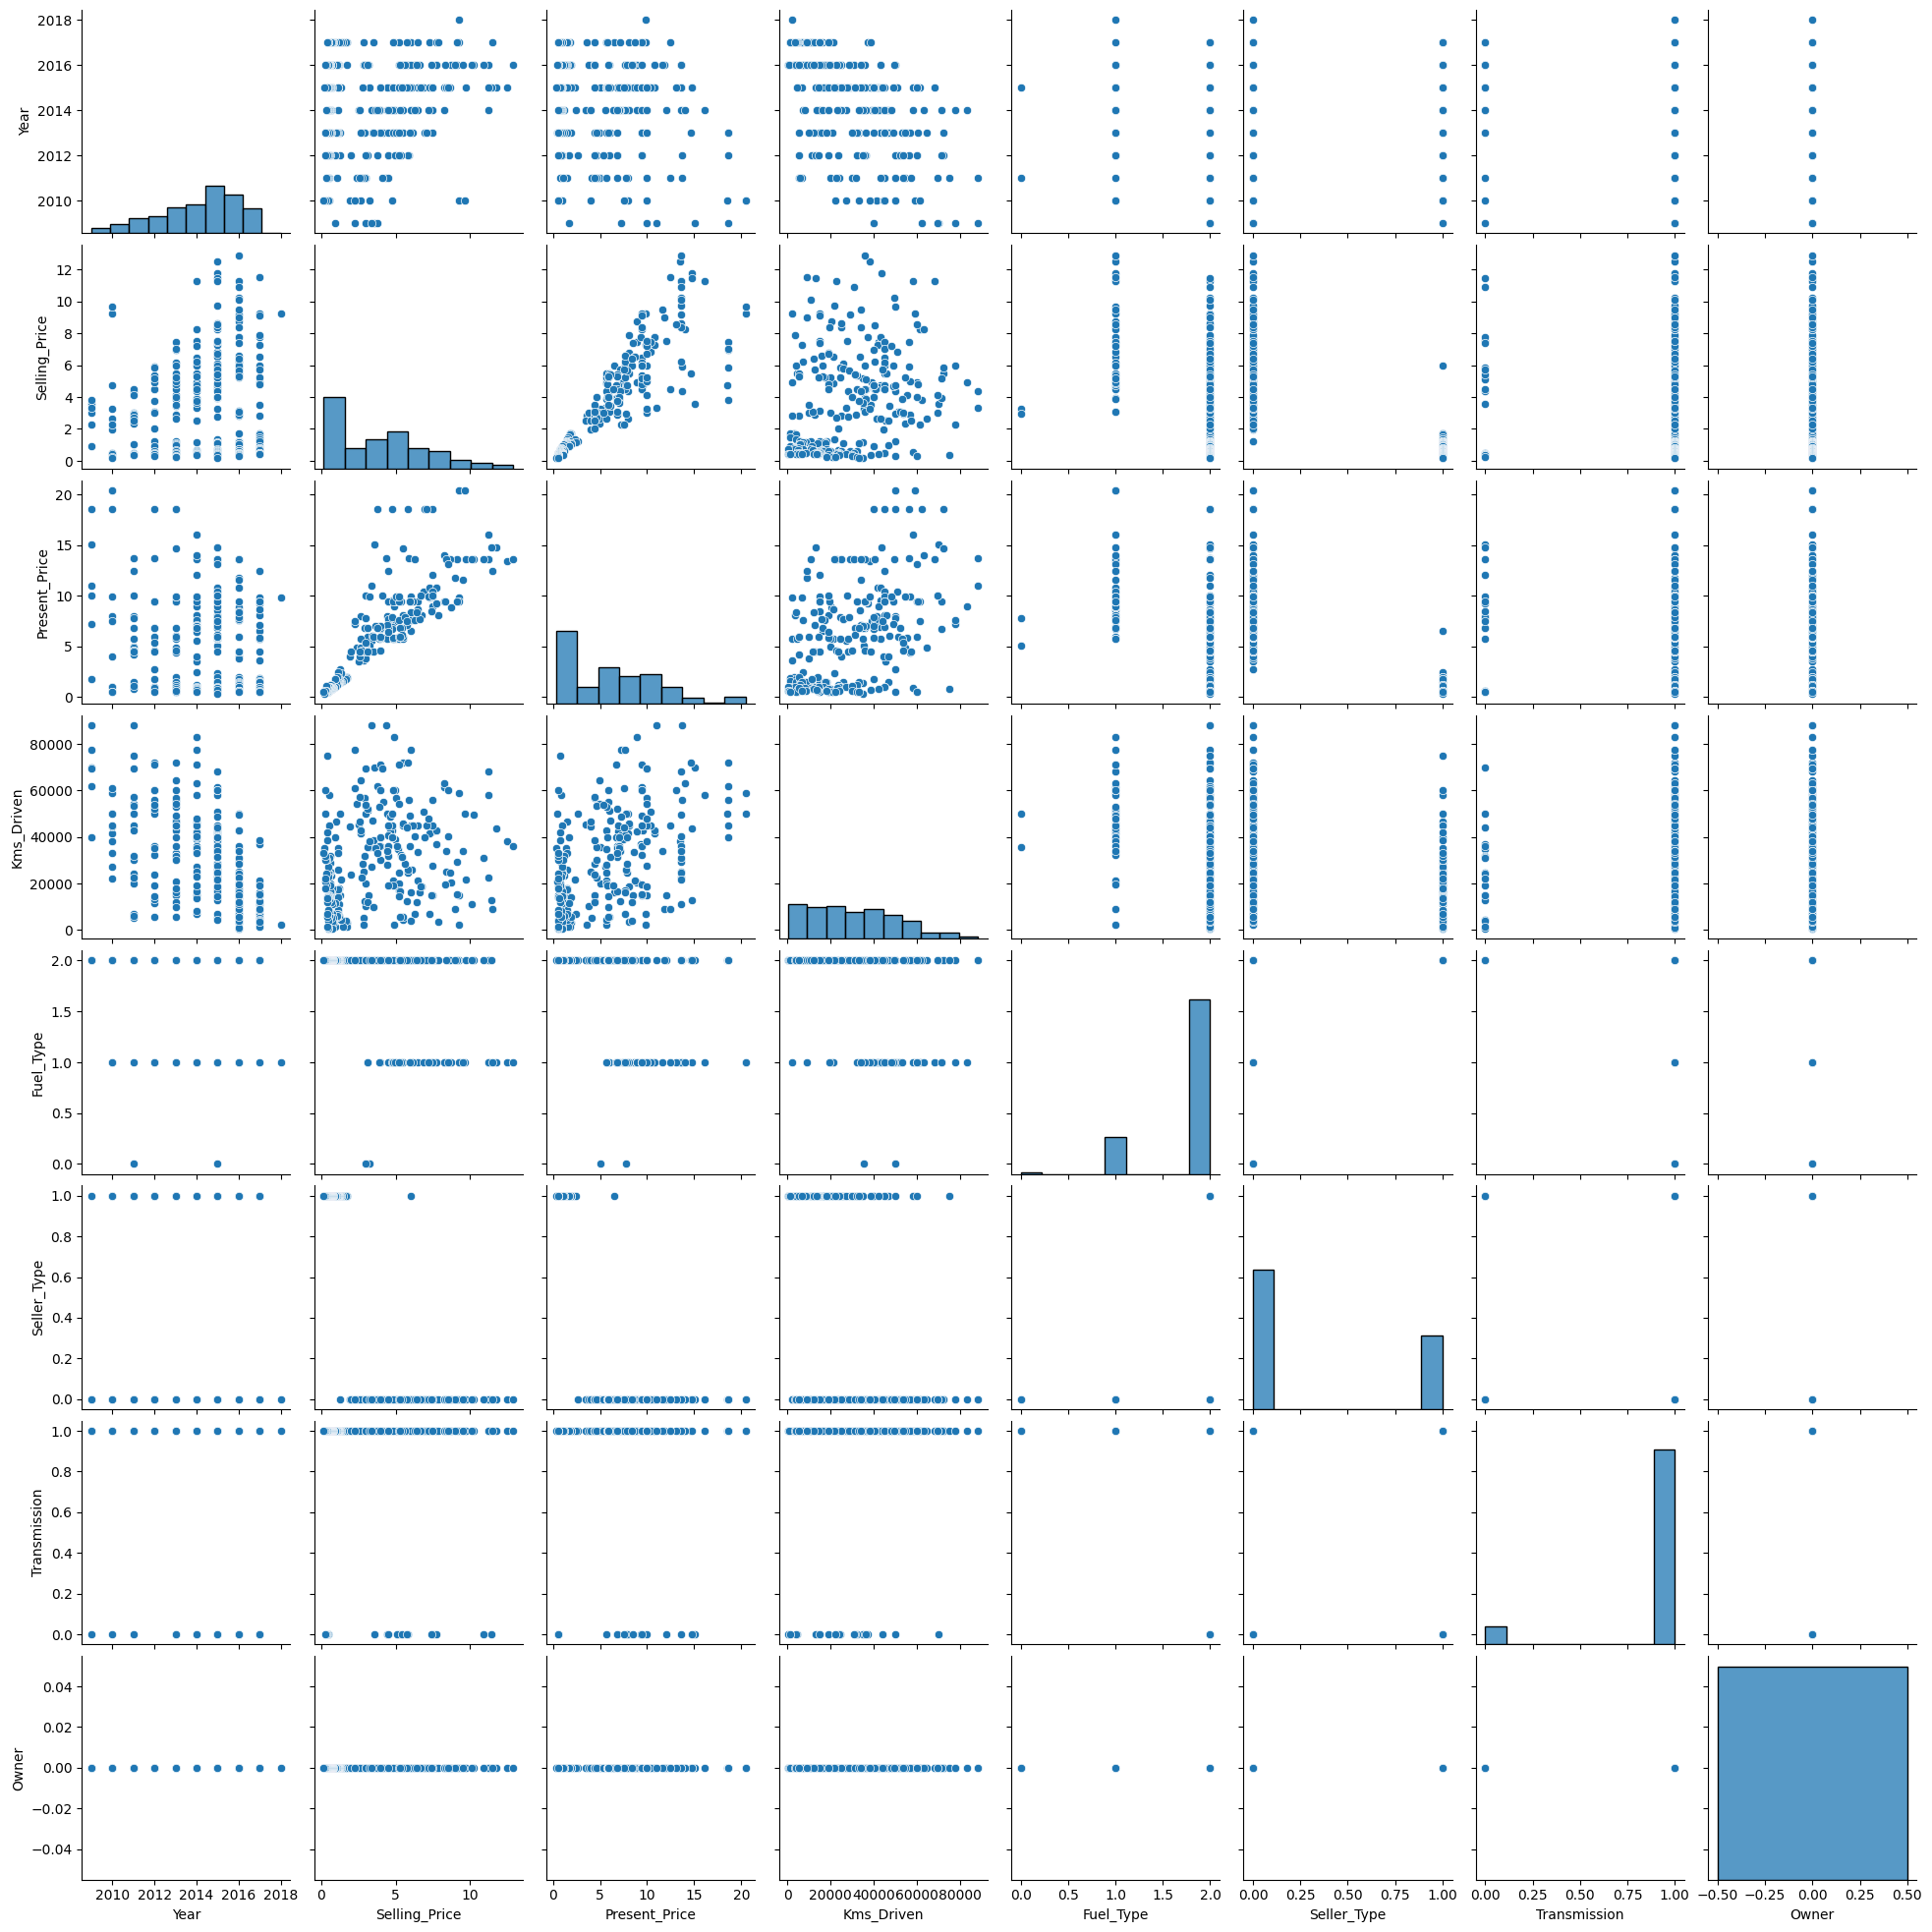

              Year  Selling_Price  Present_Price    Kms_Driven   Fuel_Type  \
count   254.000000     254.000000     254.000000    254.000000  254.000000   
mean   2014.173228       3.944803       6.186232  30867.870079    1.811024   
std       2.102490       3.088352       4.837365  19950.107626    0.411923   
min    2009.000000       0.160000       0.320000    500.000000    0.000000   
25%    2013.000000       0.962500       1.295000  15000.000000    2.000000   
50%    2015.000000       3.700000       5.900000  29611.500000    2.000000   
75%    2016.000000       5.887500       9.400000  45000.000000    2.000000   
max    2018.000000      12.900000      20.450000  88000.000000    2.000000   

       Seller_Type  Transmission  Owner  
count   254.000000    254.000000  254.0  
mean      0.346457      0.917323    0.0  
std       0.476780      0.275937    0.0  
min       0.000000      0.000000    0.0  
25%       0.000000      1.000000    0.0  
50%       0.000000      1.000000    0.0  
75%

In [ ]:
#Step 3: Analyze the Dataset

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder # Import LabelEncoder

# Convert categorical variables to numerical format for correlation calculation
# This was previously in Step 4, but needed before correlation
df['Fuel_Type'] = LabelEncoder().fit_transform(df['Fuel_Type'])
df['Seller_Type'] = LabelEncoder().fit_transform(df['Seller_Type'])
df['Transmission'] = LabelEncoder().fit_transform(df['Transmission'])


sns.pairplot(df)
plt.show()

print(df.describe())
# Now that categorical columns are numeric, correlation can be calculated
print(df.corr())

4. Build the machine learning model.
i. Normalize the dataset


In [ ]:
# Step 4: Build the machine learning model.
# i. Normalize the dataset

X = df.drop('Selling_Price', axis=1)
y = df['Selling_Price']

# Drop the 'Car_Name' column from X before splitting and scaling
# This check is redundant if Car_Name was already dropped in preprocessing
if 'Car_Name' in X.columns:
    X = X.drop('Car_Name', axis=1)
    print("Dropped 'Car_Name' column.")
else:
    print("'Car_Name' column not found in X.")

# Convert categorical features to numerical using one-hot encoding
# This step is crucial to avoid the ValueError with StandardScaler
X = pd.get_dummies(X, drop_first=True) # Use drop_first=True to avoid multicollinearity

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

scaler = StandardScaler()
# Now X_train should only contain numerical columns after get_dummies
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Optional: Print the columns of X_train_scaled to verify
# print("\nColumns in X_train_scaled (should be numerical):")
# print(pd.DataFrame(X_train_scaled, columns=X_train.columns).head())


Dropped 'Car_Name' column.


In [ ]:
# ii. Train the model

# Note: X_scaled was defined earlier, ensure it corresponds to the correct dataset (car data)
# If you re-ran the car data import later, you might need to re-calculate X_scaled
# based on the df *after* preprocessing for car data.
# Assuming X_scaled from the previous cell (`ipython-input-43-934bded9a8d0`) is the intended input
# for the car data model.
# If you meant to use X_scaled from the House data section, this part needs adjustment.

# Assuming X_scaled is the scaled data for the Car Price Prediction model:
# Re-create X and X_scaled just before splitting to be sure
X_car = df.drop('Selling_Price', axis=1)
y_car = df['Selling_Price']
if 'Car_Name' in X_car.columns:
    X_car = X_car.drop('Car_Name', axis=1)
X_car = pd.get_dummies(X_car, drop_first=True)
scaler_car = StandardScaler()
X_scaled_car = scaler_car.fit_transform(X_car)


X_train, X_test, y_train, y_test = train_test_split(X_scaled_car, y_car, test_size=0.2, random_state=0)

model = LinearRegression()
model.fit(X_train, y_train)


LinearRegression()

In [ ]:
#iii. Evaluate the model

from sklearn.metrics import mean_squared_error, r2_score

y_pred = model.predict(X_test)
print("R2 Score:", r2_score(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))

R2 Score: 0.9144342972228514
MSE: 2.1628715277876056


02.  House Price Prediction Model

In [ ]:
#02. House Price Prediction Model
#Step 1: Import the Dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_validate, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn import metrics

# Load dataset (adjust path as needed)
df = pd.read_csv('/content/drive/MyDrive/Sem 7/ML/House data.csv')
print("Shape:", df.shape)
df.head()


Shape: (4600, 18)


,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
0,2014-05-02 00:00:00,313000.0,3.0,1.50,1340,7912,1.5,0,0,3,1340,0,1955,2005,18810 Densmore Ave N,Shoreline,WA 98133,USA
1,2014-05-02 00:00:00,2384000.0,5.0,2.50,3650,9050,2.0,0,4,5,3370,280,1921,0,709 W Blaine St,Seattle,WA 98119,USA
2,2014-05-02 00:00:00,342000.0,3.0,2.00,1930,11947,1.0,0,0,4,1930,0,1966,0,26206-26214 143rd Ave SE,Kent,WA 98042,USA
3,2014-05-02 00:00:00,420000.0,3.0,2.25,2000,8030,1.0,0,0,4,1000,1000,1963,0,857 170th Pl NE,Bellevue,WA 98008,USA
4,2014-05-02 00:00:00,550000.0,4.0,2.50,1940,10500,1.0,0,0,4,1140,800,1976,1992,9105 170th Ave NE,Redmond,WA 98052,USA


In [ ]:
# Drop columns like 'Id' or 'Address' if present
df.drop(['Id', 'Address'], axis=1, errors='ignore', inplace=True)


In [ ]:
#ii. Remove null values
df = df.dropna()


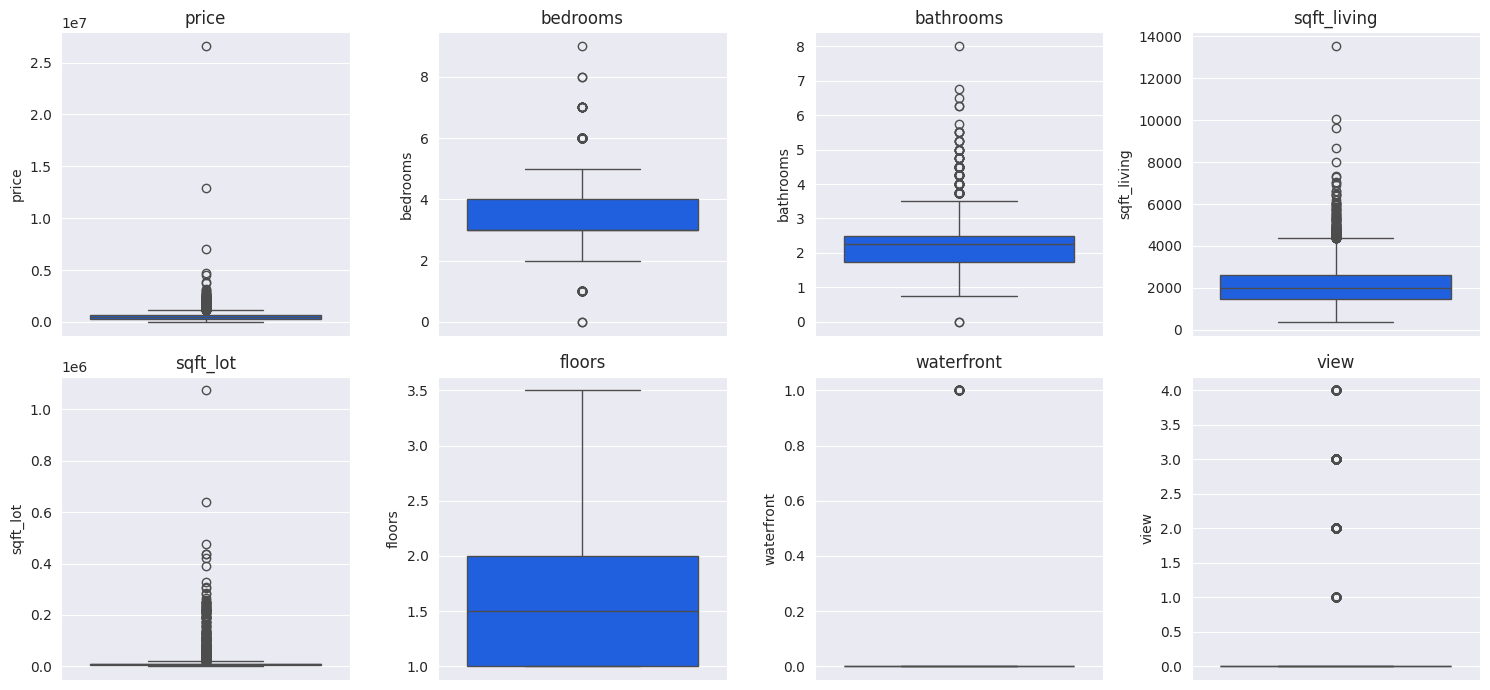

In [ ]:
#iii. Remove outliers
# Visualize with boxplots
sns.set_style('darkgrid')
colors = ['#0055ff', '#ff7000', '#23bf00']
sns.set_palette(sns.color_palette(colors))

OrderedCols = df.select_dtypes(include=['number']).columns.values

# Define the number of rows and columns for subplots
n_rows = 2
n_cols = 4
fig, ax = plt.subplots(n_rows, n_cols, figsize=(15,7), dpi=100)

# Iterate through the numeric columns, but limit the iteration to the number of available subplots
# Use zip to iterate over both the column names and the flat array of axes
for i, (col, axi) in enumerate(zip(OrderedCols, ax.flatten())):
    # No need to calculate x and y indices explicitly when using ax.flatten()
    sns.boxplot(data=df, y=col, ax=axi)
    axi.set_title(col)
    # axi.tick_params(axis='x', rotation=30) # This rotates the x-axis ticks, which are not used in a simple boxplot
    axi.tick_params(axis='y', rotation=0) # You might want to adjust y-axis ticks if column names are long

plt.tight_layout()
plt.show()

# If you want to plot ALL numeric columns, you would need to adjust the grid size (n_rows, n_cols)
# based on the number of numeric columns, or plot them in multiple figures.


In [ ]:
# Identify outliers
outliers_indexes = []
target = 'Price'

for col in df.select_dtypes(include=['number']).columns:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    min_val, max_val = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    outliers = df[(df[col] < min_val) | (df[col] > max_val)]
    outliers_indexes.extend(outliers.index.tolist())

outliers_indexes = list(set(outliers_indexes))
print(f"{len(outliers_indexes)} outliers identified.")


1152 outliers identified.


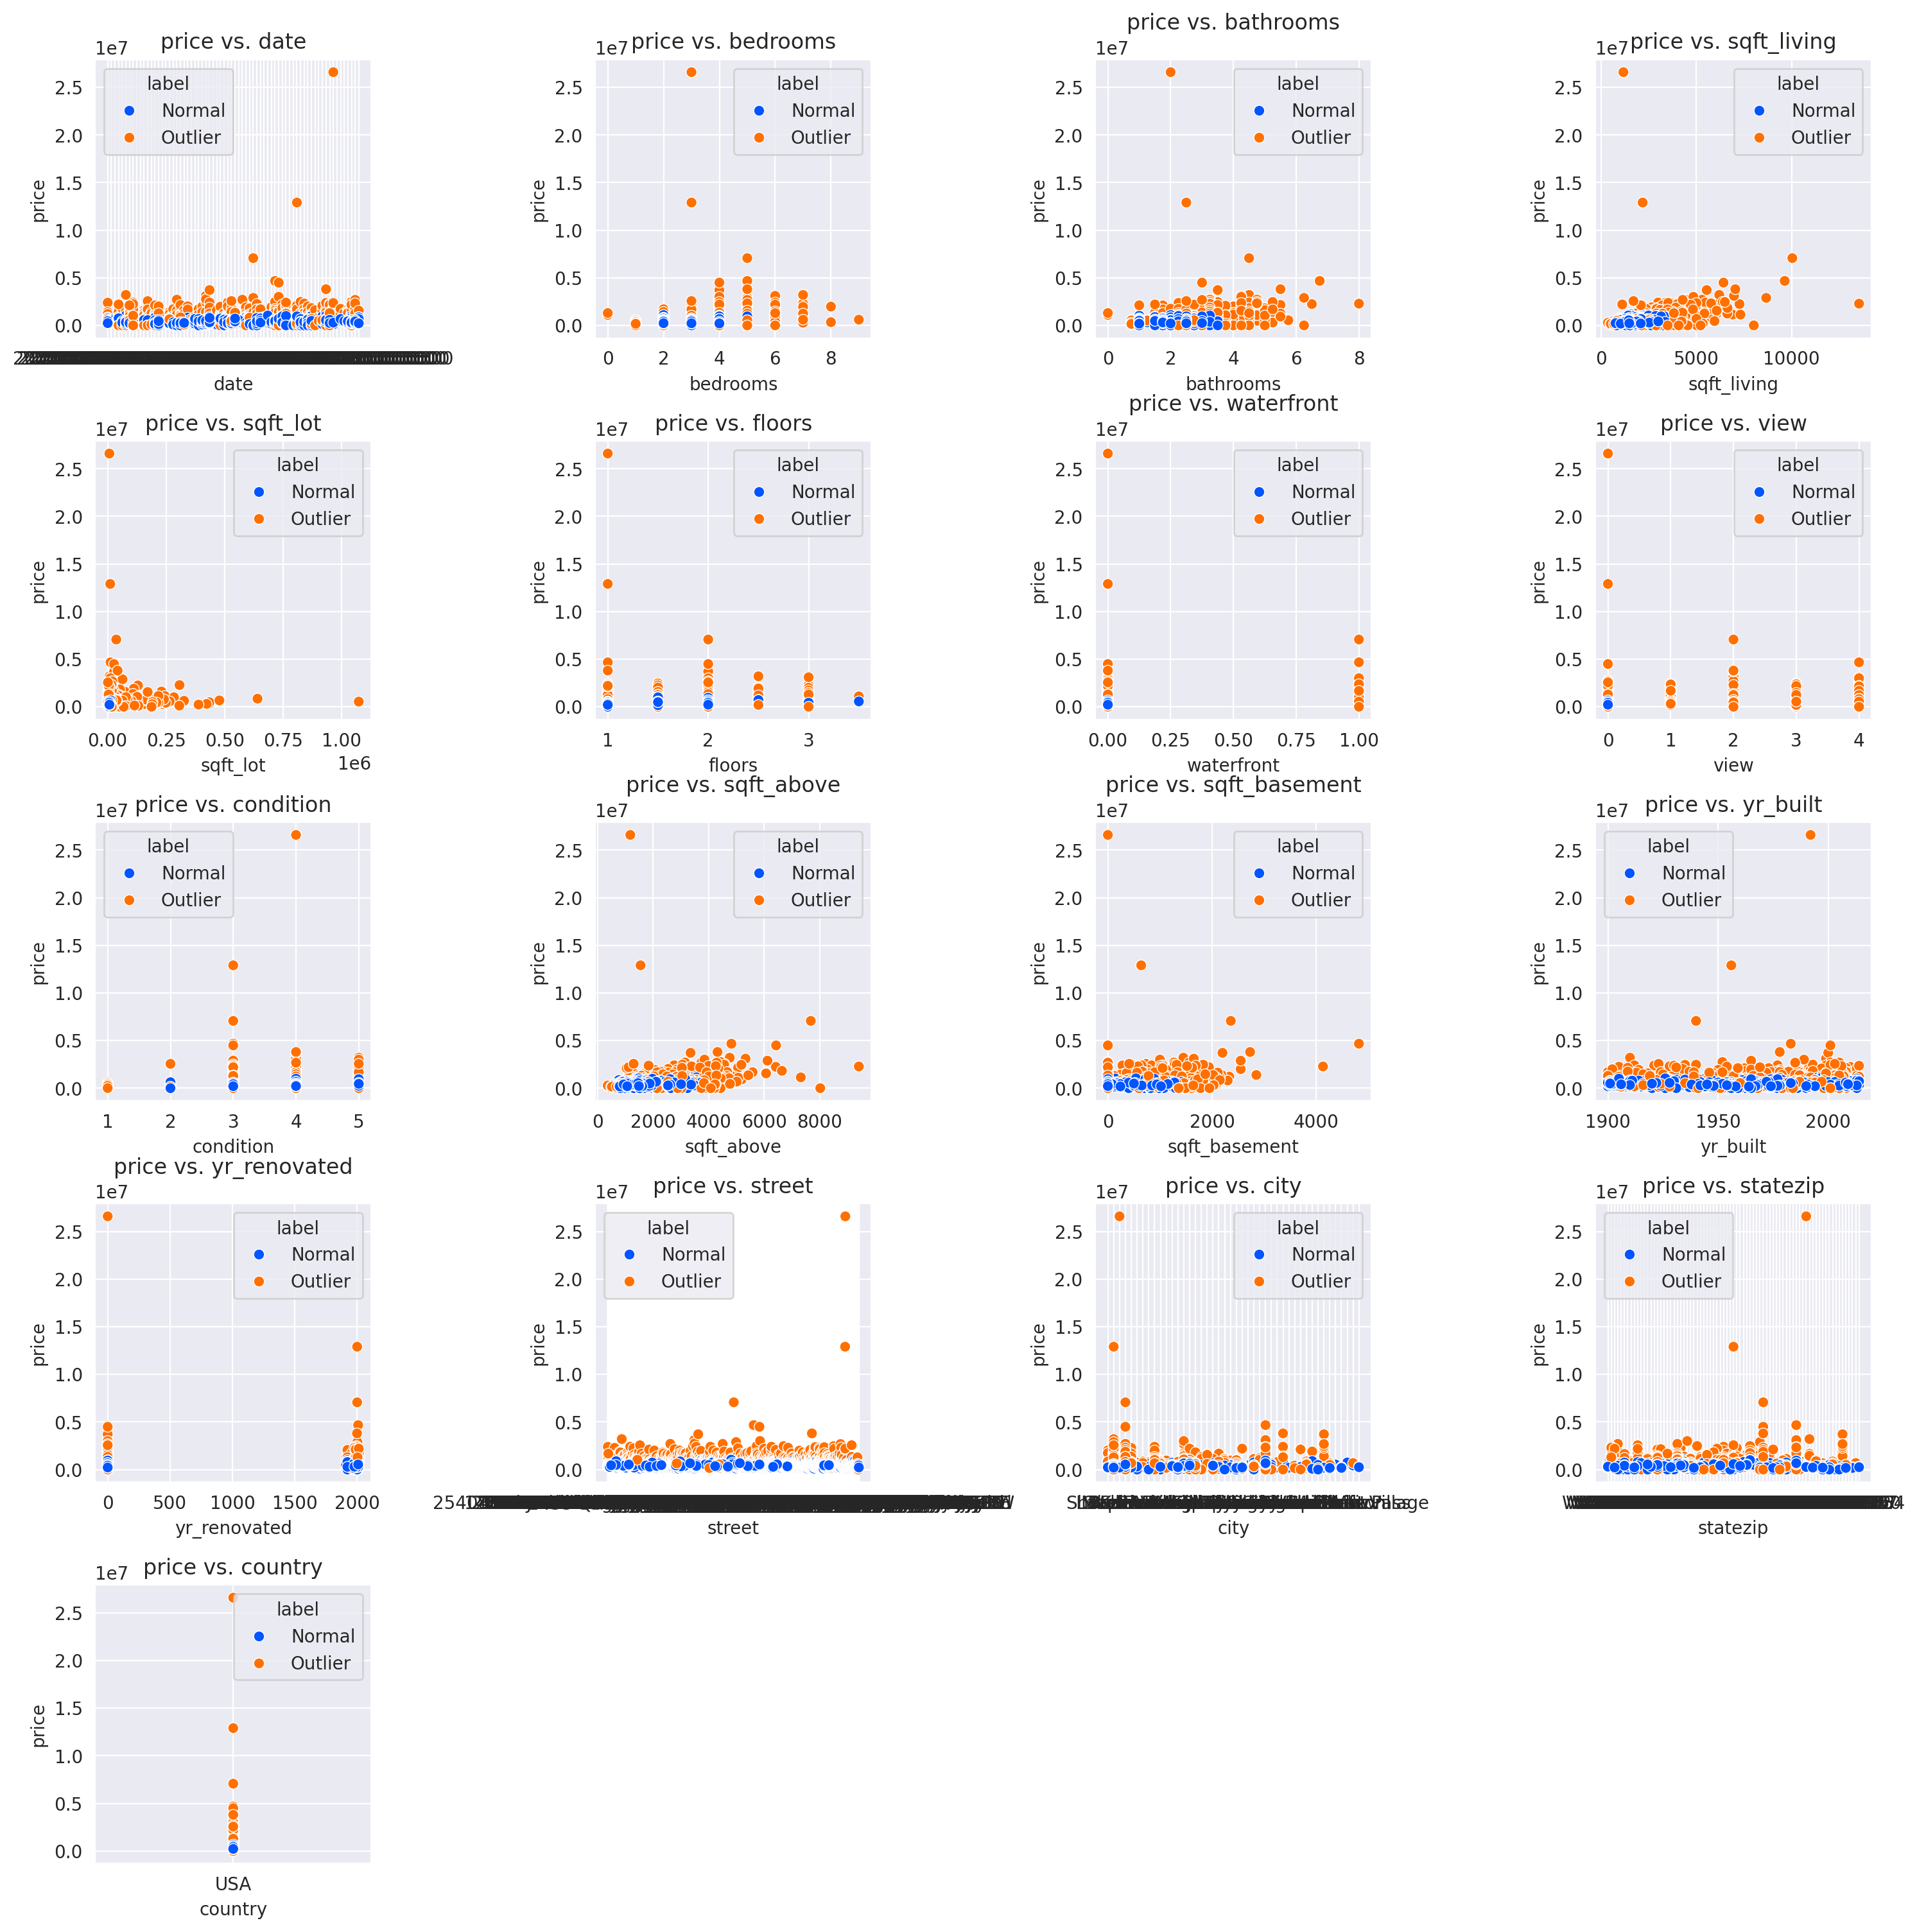

In [ ]:
# Label and visualize outliers
df1 = df.copy()
df1['label'] = 'Normal'
df1.loc[outliers_indexes, 'label'] = 'Outlier'

# Scatter plot to visualize
# Corrected 'Price' to 'price' to match the actual column name
features = df1.columns.drop(['price', 'label'])

# Calculate the required number of rows and columns for subplots
n_features = len(features)
n_cols = 4 # You can adjust the number of columns
n_rows = (n_features + n_cols - 1) // n_cols # Integer division to get enough rows

fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 3 * n_rows), dpi=200) # Adjust figsize based on number of rows

# Flatten the axes array for easy iteration
ax = ax.flatten()

for i in range(n_features):
    # Use the flattened axes array directly
    sns.scatterplot(data=df1, x=features[i], y='price', hue='label', ax=ax[i])
    # Corrected 'Price' to 'price' in the title
    ax[i].set_title(f'price vs. {features[i]}')

# Turn off any unused subplots if the number of features is less than n_rows * n_cols
for j in range(n_features, len(ax)):
    fig.delaxes(ax[j])


plt.tight_layout()
plt.show()

# Drop Outliers
df1 = df1[df1['label'] == 'Normal'].drop('label', axis=1)
df1.reset_index(drop=True, inplace=True)


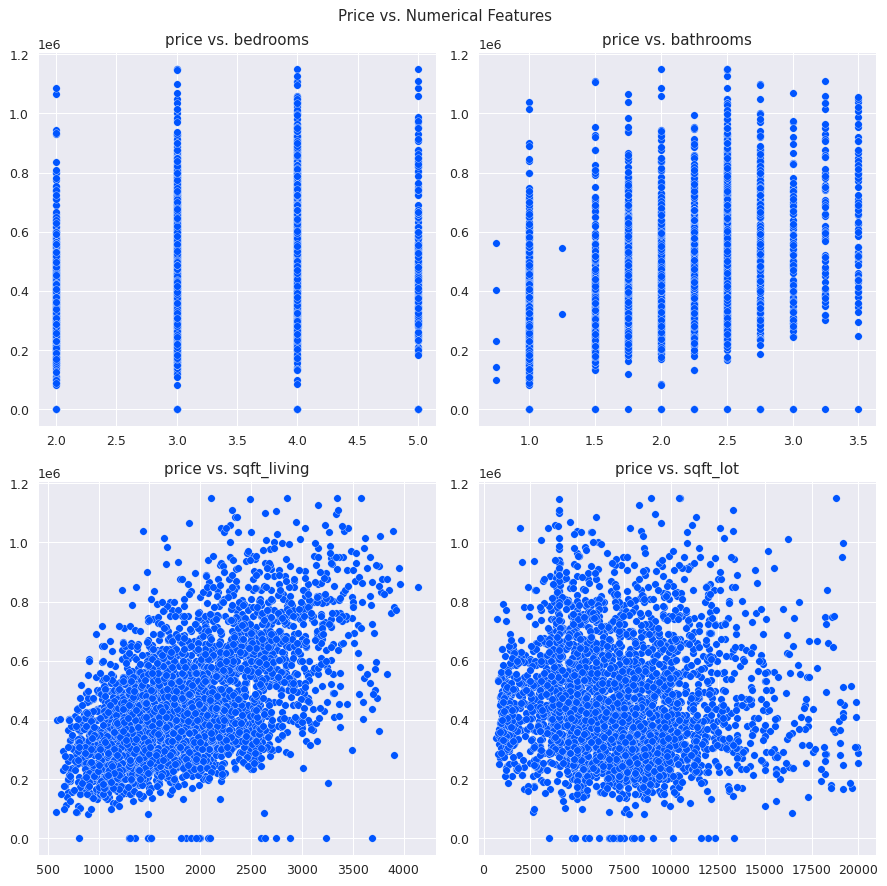

In [ ]:
num_features = df1.select_dtypes(include=['number']).columns.drop('price') # Changed 'Price' to 'price'
target = 'price' # Changed 'Price' to 'price' to be consistent with the actual column name

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,10), dpi=90)
for i in range(min(len(num_features), 4)):
    row, col = i//2, i%2
    ax[row, col].scatter(df1[num_features[i]], df1[target], color='#0055ff', edgecolors='w', linewidths=0.25)
    ax[row, col].set_title(f'{target} vs. {num_features[i]}')
plt.suptitle('Price vs. Numerical Features')
plt.tight_layout()
plt.show()

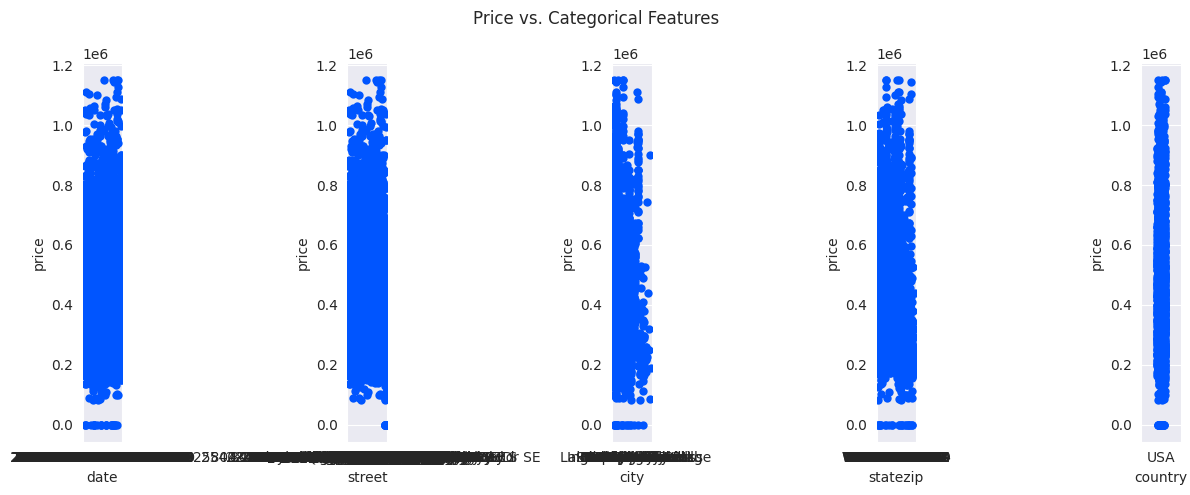

In [ ]:
cat_cols = df1.select_dtypes(include='object').columns
if not cat_cols.empty:
    fig, axes = plt.subplots(nrows=1, ncols=len(cat_cols), figsize=(12,5), dpi=100)
    for i in range(len(cat_cols)):
        # Changed 'Price' to 'price' to match the actual column name in df1
        sns.stripplot(ax=axes[i], x=cat_cols[i], y='price', data=df1, size=6, color='#0055ff')
    plt.suptitle('Price vs. Categorical Features')
    plt.tight_layout()
    plt.show()


4. Build the Model
i. Normalize the Dataset


In [ ]:
# Step 4: Build the Model
# i. Normalize the Dataset

# Change 'Price' to 'price' to match the column name after preprocessing
X = df1.drop('price', axis=1)
y = df1['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

scaler = StandardScaler()
# Ensure X_train contains only numerical columns or handle categorical columns before scaling
# Based on previous steps, df1 might contain categorical columns.
# You need to apply one-hot encoding or similar transformation before scaling.
# Add one-hot encoding here:
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

# Align columns - this is important if train/test splits result in different dummy columns
# This can happen if a category is only present in one split.
# Reindex test columns based on train columns, filling missing with 0
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)


X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [ ]:
linear_reg = LinearRegression()
linear_reg.fit(X_train_scaled, y_train)

# Coefficients
pd.DataFrame(data=np.append(linear_reg.intercept_, linear_reg.coef_),
             index=['Intercept'] + [col + " Coef." for col in X.columns],
             columns=['Value']).sort_values('Value', ascending=False)


,Value
Intercept,454591.535589
sqft_living Coef.,36498.706655
sqft_above Coef.,33221.758160
city_Seattle Coef.,15340.175786
bathrooms Coef.,14030.044787
...,...
street_2760 72nd Ave SE Coef.,-11501.677554
city_Kent Coef.,-11835.796933
date_2014-05-15 00:00:00 Coef.,-12343.876214
city_Federal Way Coef.,-12730.638142


In [ ]:
def model_evaluation(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    MAE = metrics.mean_absolute_error(y_test, y_pred)
    MSE = metrics.mean_squared_error(y_test, y_pred)
    RMSE = np.sqrt(MSE)
    R2_Score = metrics.r2_score(y_test, y_pred)
    return pd.DataFrame([MAE, MSE, RMSE, R2_Score],
                        index=['MAE', 'MSE', 'RMSE', 'R2-Score'],
                        columns=[model_name])

model_evaluation(linear_reg, X_test_scaled, y_test, 'Linear Reg.')


,Linear Reg.
MAE,8.145708e+04
MSE,1.309202e+10
RMSE,1.144204e+05
R2-Score,6.673246e-01
